# Graphs in ML - TP1 : Spectral clustering
### Dimitri Bouche (dimitri.bouche@ensae.fr)

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import scipy.spatial.distance as sd
import scipy.io as io
import sklearn.cluster as skc
import sys
import os

# Local imports
from helper import *
from graph_construction import generate_data

## 1. Graph construction

In [78]:
def similarity_matrix(X, var):
    # L2 distance matrix
    # IS IT THE SQUARE DISTANCE OR THE NORMAL DISTANCE
    dists = sd.squareform(sd.pdist(X))
    # Similarity matrix
    S = np.exp(-dists / var)
    return S

In [79]:
def build_epsilon_graph(X, var, eps):
    S = similarity_matrix(X, var)-np.eye(X.shape[0])
    S = np.maximum(S - eps, 0)
    return S

In [80]:
def build_knn_graph(X, var, k=5):
    # Remove the diagonal (self similarity)
    S = similarity_matrix(X, var)
    S_nodiag = S - np.eye(S.shape[0])
    wdir = np.zeros(S.shape)
    for i in range(0, S.shape[0]):
        neighbors_inds = np.argsort(S[i, :])[:k]
        wdir[i, neighbors_inds] = S[i, neighbors_inds]
    # The matrix is directed, we turn it into the at least k neighbors
    S = np.maximum(wdir, wdir.T)    
    return S

### Build similarity graph function

In [81]:
def build_similarity_graph(X, var, eps, k):
    assert eps + k != 0, "Choose either epsilon graph or k-nn graph"
    if eps != 0:
        return build_epsilon_graph(X, var, eps)
    else:
        return build_knn_graph(X, var, k)

### Plot similarity graph

In [82]:
def plot_similarity_graph(X, Y, var, eps, k):
    W = build_similarity_graph(X, var, eps, k)
    plot_graph_matrix(X,Y,W)   

In [83]:
# Parameters
n_samples = 10
gen_pam = 0.1
var = 0.3

In [84]:
# Generate data from worst_case_blob function
X, Y = generate_data.worst_case_blob(n_samples, gen_pam)

### Epsilon graph

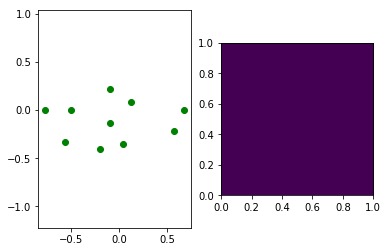

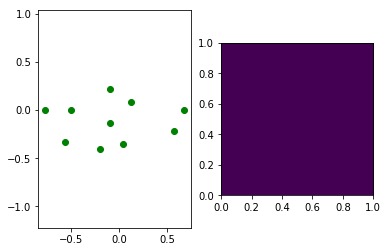

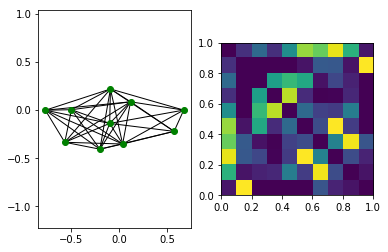

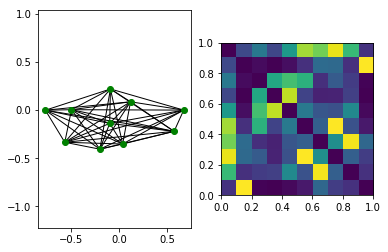

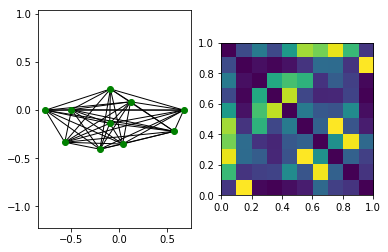

In [85]:
# Plot graph and similarity map for different values of epsilon 
epss = [1, 0.5, 0.05, 0.01, 0.005]
for eps in epss:
    plot_similarity_graph(X, Y, var, eps, 0)

In [86]:
def how_to_choose_epsilon(X, var, perturbation=0.0000001):
    S = similarity_matrix(X, var)
    max_tree = max_span_tree(S)
    a = max_tree * S
    epsilon =  np.min(a[a != 0])
    return epsilon - perturbation

### Pourquoi choisit-on $\epsilon$ comme ça ?
Le "maximum spanning tree" ou arbre couvrant est un graphe dont l'ensemble d'arrête est inclus dans celles du graphe original et qui relie tout les noeuds de celui-ci. Dès lors si l'on prend $\epsilon$ égale au poid sur l'arrête la plus faible de l'arbre couvrant on s'assure une parcimonie maximale ($\epsilon$ le plus grand possible) sans toutefois casser la connectivité. Néanmoins, si l'on prend $\epsilon$ exactement égal à ce poid minimal, on casse quand même l'arrête, il faut donc ajouter à cet $\epsilon$ optimal un légère perturbation strictement positive.

0.16160283530944744


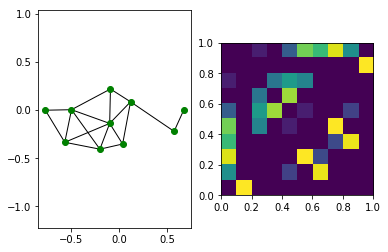

In [87]:
# How to chose epsilon test
eps_star = how_to_choose_epsilon(X, var)
print(eps_star)
W = build_similarity_graph(X, var, eps_star, 0)
plot_graph_matrix(X,Y,W)

On constate effectivement que le graphe est parcimonieux (peu de connections) mais connecté (même les points extrêmes). C'est ce que nous voulions.

### Neighbors graph

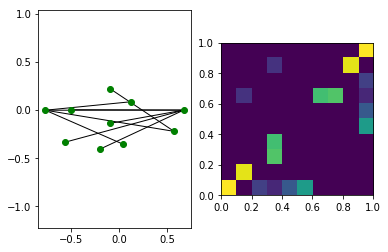

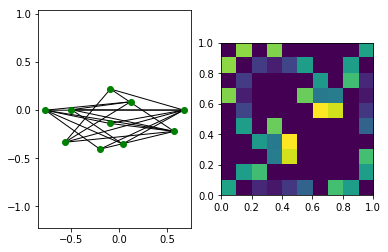

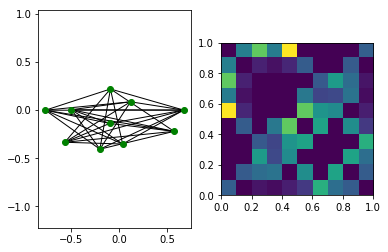

In [88]:
# Plot graph and similarity map for different number of neighbors
ks = [1, 3, 5]
for k in ks:
    plot_similarity_graph(X, Y, var, 0, k)

### 1.1 What is the purpose of the option parameter (gen_pam) in worst case blob ?
Ce paramètre a pour objectif d'ajouter un point "aberrant" au dataset (on ajoute un dernier point dont la première coordonnée est le maximum des coordonnées de tous les autres points auquel on ajoute en plus le paramètre **gen_pam** et la seconde coordonnée est 0. Dès lors plus **gen_pam** est grand, plus le point en question sera aberrant et donc difficile à connecter au reste (on devra forcément prendre un $\epsilon$ plus petit).

### 1.2 What happens when you change the generating parameter of worst_case_blob.m in how_to_choose_espilon.m and run the function? What if the parameter is very large?
Quand on change le paramètre **gen_pam**, comme justifié dans la précédente question, $\epsilon$ augmente. On le voit empiriquement dans les quelques testes ci-dessous. Quand **gen_pam** devient très grand, $\epsilon$ tend vers 0.

Text(0,0.5,'epsilon*')

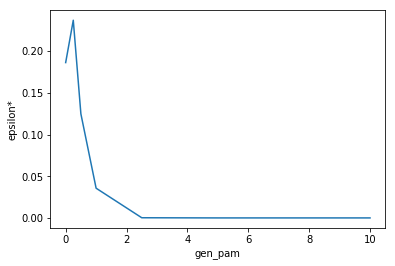

In [89]:
# Find epsilon optimal for several increasing values of gen_pams
gen_pams = [0, 0.25, 0.5, 1, 2.5, 5, 7.5, 10]
eps_stars = []
for gen_pam in gen_pams:
    X, Y = generate_data.worst_case_blob(n_samples, gen_pam)
    eps_star = how_to_choose_epsilon(X, var)
    eps_stars.append(eps_star)
plt.plot(gen_pams, eps_stars)
plt.xlabel("gen_pam")
plt.ylabel("epsilon*")

### 1.3. Using plot_similarity_graph and one of the datasets, compare k-nn to ε graphs. When is it easier to build a connected graph using k-nn? When using ε graphs?

In [90]:
# Load the data 2blobs
data_blobs = io.loadmat(os.getcwd() + "/data/data_2blobs.mat")
X2blobs, Y2blobs = data_blobs["X"], data_blobs["Y"]

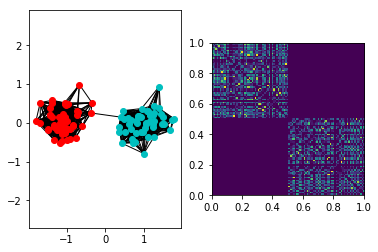

In [91]:
# Chose epsilon and plot the corresponding epsilon graph
eps_star = how_to_choose_epsilon(X2blobs, var)
plot_similarity_graph(X2blobs, Y2blobs, var, eps_star - perturbation, 0)

Nous observons bien les deux aggrégats de points, le graphe reste toutefois connecté par un seul lien entre les deux aggrégats, ce qui montre que le choix de $\epsilon$ est pertinent.

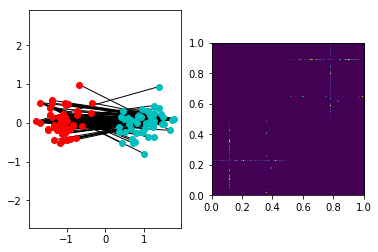

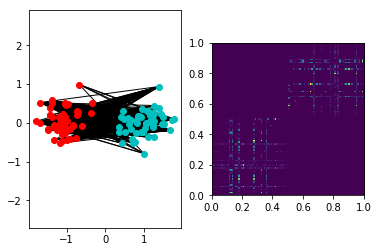

In [92]:
plot_similarity_graph(X2blobs, Y2blobs, var, 0, 1)
plot_similarity_graph(X2blobs, Y2blobs, var, 0, 5)

Il est beaucoup plus difficile d'obtenir un graphe qui soit à la fois connecté et parcimonieux dans ses liens entre les deux composantes en utilisant la méthodes de k plus proches voisins. effectivement, même avec un seul voisin les lien entre les deux blobs sont extrêmement nombreux alors que les liens intra blobs sont peu nombreux. On perd donc beaucoup d'information par cette méthode ce qui n'est pas souhaitable. Dès lors la solution $\epsilon$-graphe semble beaucoup plus pertinente dans notre cas.

# 2. Spectral clustering

### build_laplacian function

In [94]:
def build_laplacian(W, laplacian_normalization=""):
#  laplacian_normalization:
#      string selecting which version of the laplacian matrix to construct
#      either 'unn'normalized, 'sym'metric normalization
#      or 'rw' random-walk normalization
    D = np.diag(W.sum(axis=0))
    L = D - W
    if laplacian_normalization=="sym":
        Dinv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
        return np.dot(np.dot(Dinv_sqrt, L), Dinv_sqrt)
    elif laplacian_normalization=="rw":
        Dinv = np.diag(1 / np.diag(D))
        return np.dot(Dinv, L)
    else:
        return L

### Spectral clustering function

In [97]:
def spectral_clustering(L, chosen_eig_indices, num_classes=2):
#  Input
#  L:
#      Graph Laplacian (standard or normalized)
#  chosen_eig_indices:
#      indices of eigenvectors to use for clustering
#  num_classes:
#      number of clusters to compute (defaults to 2)
#
#  Output
#  Y:
#      Cluster assignments


    #################################################################
    # compute eigenvectors                                          #
    # U = (n x n) eigenvector matrix                                #
    # E = (n x n) eigenvalue diagonal matrix (sorted)               #
    #################################################################

    E, U = np.linalg.eig(L)
    order = np.argsort(E)
    E, U = np.diag(E[order]), U[:, order]

    #################################################################
    #################################################################

    #################################################################
    # compute the clustering assignment from the eigenvector        #
    # Y = (n x 1) cluster assignments [1,2,...,c]                   #
    #################################################################
    
    kmeans_clustering = skc.KMeans(n_clusters=num_classes)
    kmeans_clustering.fit(U[:, chosen_eig_indices])

    Y = kmeans_clustering.predict(U[:, chosen_eig_indices])
    
    #################################################################
    #################################################################
    return Y


### Two blobs clustering

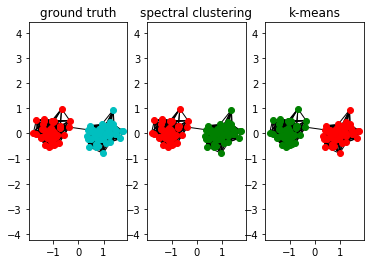

In [98]:
# Load the data 2blobs
data_blobs = io.loadmat(os.getcwd() + "/data/data_2blobs.mat")
X2blobs, Y2blobs = data_blobs["X"], data_blobs["Y"]

# automatically infer number of labels from samples
num_classes = len(np.unique(Y2blobs))

# exponential_euclidean's sigma^2
var = 0.3

# Laplacian normalization choice
laplacian_normalization = 'unn'

# indices of the ordered eigenvalues to pick
chosen_eig_indices = [1]

# Build graph
epsilon = how_to_choose_epsilon(X2blobs, var)
W2blobs = build_epsilon_graph(X2blobs, var, epsilon)

# Build Laplacian
L2blobs = build_laplacian(W2blobs, laplacian_normalization)
Y_rec = spectral_clustering(L2blobs, chosen_eig_indices, num_classes=2)

# Plot clustering results (compare to ground truth and kmeans)
plot_clustering_result(X2blobs, Y2blobs, L2blobs, Y_rec,skc.KMeans(num_classes).fit_predict(X2blobs))